In [1]:
import os
import random
import h5py
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import hdf5storage
from IPython.core.display import Image, display
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
from numpy import ma
import scipy.io as sio
from IPython.display import Image
from matplotlib import cm as CM

In [3]:
import mat73
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers 
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
Data_Foldername = './CTW2019_Dataset_HDF5_Mat'

Meas_Comb_h =    "%s/h_Estimated_CTW_Train.mat" % (Data_Foldername)
Meas_Comb_r =    "%s/r_Position_CTW_Train.mat" % (Data_Foldername)
Meas_Comb_SNR =   "%s/SNR_CTW_Train.mat" % (Data_Foldername)
# Traniningsize 
TrainingsSize = 0.9# 90 %
channel_r=hdf5storage.loadmat(Meas_Comb_r)
channel_h=hdf5storage.loadmat(Meas_Comb_h)
h_estimated=channel_h['h_Estimated']
h_estimated = np.abs(h_estimated)
r_estimated=channel_r['r_Position']
print("shape of h_estimated:",  h_estimated.shape)
print("shape of r_estimated:",  r_estimated.shape)

shape of h_estimated: (17486, 16, 924)
shape of r_estimated: (17486, 3)


In [4]:
nb_epoch =50                           # number of learning epochs
batch_sizes = 256            # size of batches for calculation the gradient

# Number of Antennas 
Nb_Antennas = [2,4,8,16]

# OutputName
#Filename_Pre = '/content/drive/My Drive/Indoor_Positioning_Data/Results/';

# Mean_Error_Train = np.empty([len(Nb_Antennas)])
# Mean_Error_Test = np.empty([len(Nb_Antennas)])
# Schuffle
shuffling_index =random.sample(range(r_estimated[:,0].size),r_estimated[:,0].size);
h_estimated = h_estimated[shuffling_index,:,:]
r_estimated =  r_estimated[shuffling_index,:]
    
# Split Data
h_estimated_train_saved = h_estimated[0:int(TrainingsSize*r_estimated[:,0].size),:,:]
Positions_train =   r_estimated[0:int(TrainingsSize*r_estimated[:,0].size),:]
h_estimated_test_saved =  h_estimated[int(TrainingsSize*r_estimated[:,0].size):,:]
Positions_test =    r_estimated[int(TrainingsSize*r_estimated[:,0].size):,:]
Length_Test = len(Positions_test[:,0])
del h_estimated
print("shape of h_estimated_train:", h_estimated_train_saved.shape)
print("shape of h_estimated_test:",  h_estimated_test_saved.shape)
print("shape of train labels:",  Positions_train.shape)
print("shape of train labels:",  Positions_test.shape)

shape of h_estimated_train: (15737, 16, 924)
shape of h_estimated_test: (1749, 16, 924)
shape of train labels: (15737, 3)
shape of train labels: (1749, 3)


In [5]:
def dist(y_true, y_pred):    
    return tf.reduce_mean((tf.sqrt(tf.square(tf.abs(y_pred[:,0]-y_true[:,0]))+tf.square(tf.abs(y_pred[:,1]-y_true[:,1]))+tf.square(tf.abs(y_pred[:,2]-y_true[:,2])))))

def true_dist(y_true, y_pred):    
    return (np.sqrt(np.square(np.abs(y_pred[:,0]-y_true[:,0]))+np.square(np.abs(y_pred[:,1]-y_true[:,1]))+np.square(np.abs(y_pred[:,2]-y_true[:,2]))))

In [0]:
h_estimated_train_saved=np.reshape(h_estimated_train_saved,(h_estimated_train_saved.shape[0],h_estimated_train_saved.shape[1],h_estimated_train_saved.shape[2],1))
h_estimated_test_saved=np.reshape(h_estimated_test_saved,(h_estimated_test_saved.shape[0],h_estimated_test_saved.shape[1],h_estimated_test_saved.shape[2],1))

print("shape of h_estimated_train:", h_estimated_train_saved.shape)
print("shape of h_estimated_test:",  h_estimated_test_saved.shape)
print("shape of train labels:",  Positions_train.shape)
print("shape of train labels:",  Positions_test.shape)

In [6]:
nn_input  = Input((16,924))
nn_output = Flatten()(nn_input)
nn_output = Dense(256,activation='relu')(nn_output)
nn_output = Dense(256,activation='relu')(nn_output)
nn_output = Dense(256,activation='relu')(nn_output)
nn_output = Dense(3,activation='linear')(nn_output)
nn = Model(inputs=nn_input,outputs=nn_output)
nn.compile(optimizer='Adam', loss='mse',metrics=[dist])
nn.summary()


# Train Neural Network
# for b in batch_sizes:
b=256
train_hist = nn.fit(x=h_estimated_train_saved,y=Positions_train,batch_size=b,epochs=nb_epoch,validation_data=(h_estimated_test_saved, Positions_test))

#save weights
nn.save_weights('FNN1_abs_h_16_Antennas.h5')
# Evaluate Performance
r_Positions_pred_train = nn.predict(h_estimated_train_saved)
r_Positions_pred_test = nn.predict(h_estimated_test_saved)
errors_train = true_dist(Positions_train,r_Positions_pred_train)
errors_test  = true_dist(Positions_test,r_Positions_pred_test)

Mean_Error_Train =  np.mean(np.abs(errors_train))
Mean_Error_Test = np.mean(np.abs(errors_test))
print("Mean error on Train area:",  Mean_Error_Train)
print("Mean error on Test  area:",Mean_Error_Test)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 924)]         0         
_________________________________________________________________
flatten (Flatten)            (None, 14784)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3784960   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 3,917,315
Trainable params: 3,917,315
Non-trainable params: 0
___________________________________________________

Epoch 50/50
15737/15737 [==============================] - 2s 152us/sample - loss: 0.0422 - dist: 0.2966 - val_loss: 0.0581 - val_dist: 0.3390
Mean error on Train area: 0.28982022609032354
Mean error on Test  area: 0.3389811306734145


In [8]:
train_hist = nn.fit(x=h_estimated_train_saved,y=Positions_train,batch_size=b,epochs=nb_epoch,validation_data=(h_estimated_test_saved, Positions_test))

#save weights
nn.save_weights('FNN1_abs_h_16_Antennas.h5')
# Evaluate Performance
r_Positions_pred_train = nn.predict(h_estimated_train_saved)
r_Positions_pred_test = nn.predict(h_estimated_test_saved)
errors_train = true_dist(Positions_train,r_Positions_pred_train)
errors_test  = true_dist(Positions_test,r_Positions_pred_test)

Mean_Error_Train =  np.mean(np.abs(errors_train))
Mean_Error_Test = np.mean(np.abs(errors_test))
print("Mean error on Train area:",  Mean_Error_Train)
print("Mean error on Test  area:",Mean_Error_Test)


Train on 15737 samples, validate on 1749 samples
Epoch 1/50
15737/15737 [==============================] - 39s 3ms/sample - loss: 0.0125 - dist: 0.1642 - val_loss: 0.0297 - val_dist: 0.2330
Epoch 2/50
15737/15737 [==============================] - 5s 315us/sample - loss: 0.0122 - dist: 0.1621 - val_loss: 0.0337 - val_dist: 0.2522
Epoch 3/50
15737/15737 [==============================] - 7s 463us/sample - loss: 0.0150 - dist: 0.1788 - val_loss: 0.0295 - val_dist: 0.2295
Epoch 4/50
15737/15737 [==============================] - 3s 217us/sample - loss: 0.0128 - dist: 0.1667 - val_loss: 0.0316 - val_dist: 0.2431
Epoch 5/50
15737/15737 [==============================] - 3s 164us/sample - loss: 0.0139 - dist: 0.1734 - val_loss: 0.0330 - val_dist: 0.2509
Epoch 6/50
15737/15737 [==============================] - 4s 244us/sample - loss: 0.0121 - dist: 0.1615 - val_loss: 0.0285 - val_dist: 0.2296
Epoch 7/50
15737/15737 [==============================] - 4s 244us/sample - loss: 0.0107 - dist: 0.1

Text(0.5,0,'Distance error')

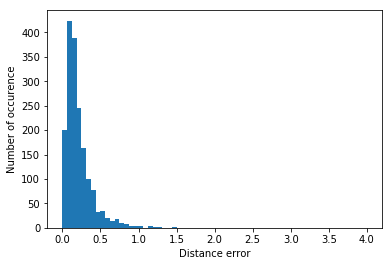

In [9]:
# Histogramm of errors on test Area
errors = true_dist(r_Positions_pred_test , Positions_test)
plt.hist(errors,bins=64,range=(0,4))
plt.ylabel('Number of occurence')
plt.xlabel('Distance error')

In [10]:
import pickle
with open('FNN1_magnitude_h_16_Antenna_Mean_TestError', 'wb') as f:
    pickle.dump([errors], f)

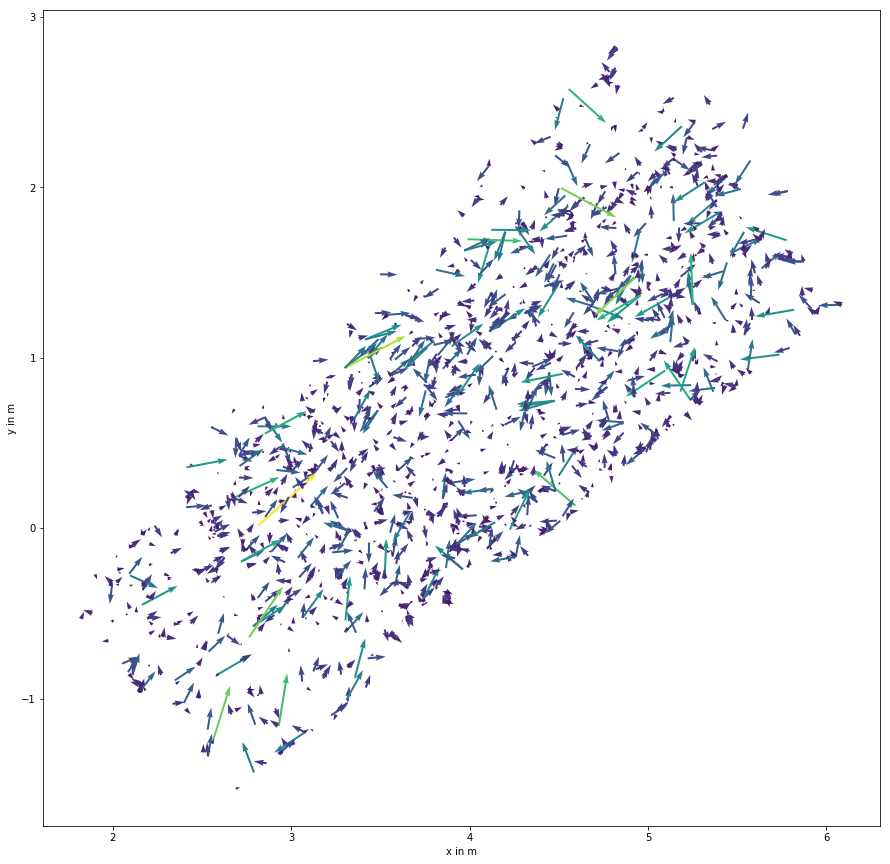

In [11]:
# Error Vector over Area in XY
error_vectors = np.real(r_Positions_pred_test - Positions_test)
plt.figure(figsize=(15,15))
plt.quiver(np.real(Positions_test[:,0]),np.real(Positions_test[:,1]),error_vectors[:,0],error_vectors[:,1],errors)
plt.xlabel("x in m")
plt.ylabel("y in m")
plt.show()